# Maze with q-leaning

In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

### Definition of the environment

In [61]:
grid_size = (10, 11)
grid_line = grid_size[0]
grid_col = grid_size[1]

goal_state = (grid_line - 1, grid_col - 1)
actions = ["up", "down", "left", "right"]

In [62]:
rewards = np.array([
    [  0, -10,   0,   0, -10,   0,   0,   0, -10,   0,   0],
    [  0, -10,   0, -10, -10,   0, -10,   0,   0,   0,   0],
    [  0,   0,   0,   0,   0,   0, -10,   0, -10, -10,   0],
    [  0, -10, -10, -10,   0, -10, -10,   0,   0,   0,   0],
    [  0,   0,   0,   0,   0,   0,   0, -10, -10,   0,   0],
    [-10, -10,   0, -10,   0, -10,   0,   0,   0,   0,   0],
    [  0,   0,   0,   0,   0,   0,   0, -10, -10,   0,   0],
    [  0, -10, -10, -10,   0, -10, -10,   0,   0,   0,   0],
    [  0,   0,   0,   0,   0,   0,   0,   0, -10, -10,   0],
    [  0, -10,   0,   0,   0,   0, -10,   0,   0,   0,  50]
])
rewards[goal_state] = 10

rewards

array([[  0, -10,   0,   0, -10,   0,   0,   0, -10,   0,   0],
       [  0, -10,   0, -10, -10,   0, -10,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, -10,   0, -10, -10,   0],
       [  0, -10, -10, -10,   0, -10, -10,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, -10, -10,   0,   0],
       [-10, -10,   0, -10,   0, -10,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, -10, -10,   0,   0],
       [  0, -10, -10, -10,   0, -10, -10,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, -10, -10,   0],
       [  0, -10,   0,   0,   0,   0, -10,   0,   0,   0,  10]])

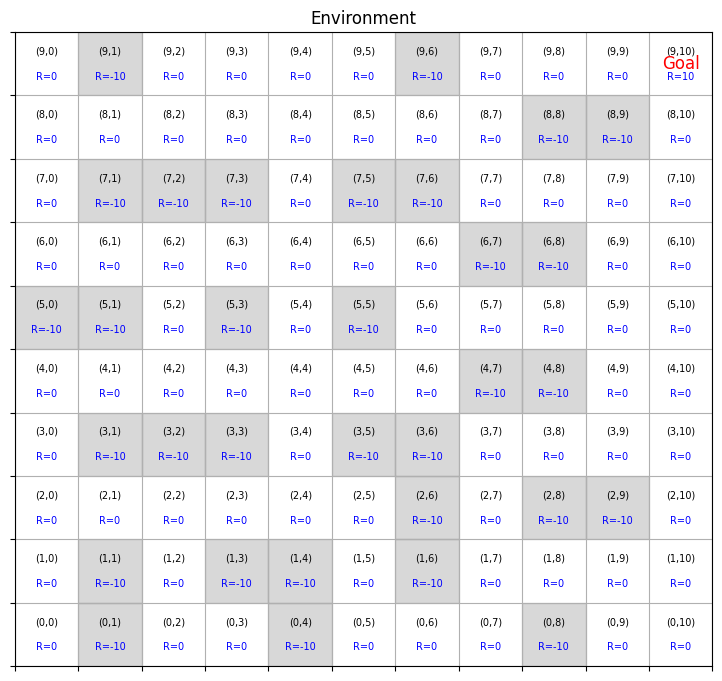

In [63]:
fig, ax = plt.subplots(figsize=(9, 9))

for i in range(grid_line):
    for j in range(grid_col):
        # Display of contact details and rewards
        ax.text(j, i + 0.2, f"({i},{j})", ha='center', va='center', fontsize=7)
        ax.text(j, i - 0.2, f"R={rewards[i, j]}", ha='center', va='center', color='blue', fontsize=7)
        
        # Walls in gray
        if rewards[i, j] < 0 and (i, j) != goal_state:
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='gray', alpha=0.3))
        
        # Goal in red
        if (i, j) == goal_state:
            ax.text(j, i, "Goal", ha='center', va='center', color='red', fontsize=12)


ax.set_xticks(np.arange(- 0.5, grid_col, 1))
ax.set_yticks(np.arange(- 0.5, grid_line, 1))
ax.grid(True)
ax.set_aspect('equal')
ax.set_xlim(- 0.5, grid_col - 0.5)
ax.set_ylim(- 0.5, grid_line - 0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Environment")

plt.show()

### Creating Q-table

In [64]:
q_table = np.zeros((grid_line * grid_col, len(actions)))

### Helper functions

In [65]:
def state_to_index(state):
    """Convert (x,y) state to a single integer index"""
    return state[0] * grid_col + state[1]

def index_to_state(index):
    """Convert integer index to (x, y) state"""
    return (index // grid_col, index % grid_col)

def get_next_state(state, action):
    """Apply action and return next state (stay in bounds)"""
    x, y = state

    potential_x, potential_y = x, y
    if action == "up":
        potential_x = min(x + 1, grid_line - 1)
    elif action == "down":
        potential_x = max(0, x - 1)
    elif action == "left":
        potential_y = max(0, y - 1)
    elif action == "right":
        potential_y = min(grid_col - 1, y + 1)

    if rewards[potential_x, potential_y] < 0 and (potential_x, potential_y) != goal_state:
        return state    
    else:
        return (potential_x, potential_y)

def get_reward(state):
    """Return a reward for landing in a state"""
    i, j = state
    return rewards[i, j]

### Q-learning hyperparameters

In [66]:
alpha = 0.1         # learning rate
gamma = 0.9         # discount factor
epsilon = 0.2       # exploration rate
episodes = 10000    # training episodes

### Training loop

In [67]:
for _ in range(episodes):
    state = (0, 0)      # start state
    while state != goal_state:
        # choose an action (epsilon-greedy)
        if random.uniform(0, 1) < epsilon:
            action_index = random.randint(0, len(actions) - 1)      # exploration
        else:
            action_index = int(np.argmax(q_table[state_to_index(state)]))   # exploitation

        action = actions[action_index]
        next_state = get_next_state(state, action)
        reward = get_reward(next_state)

        # Q-learning update
        state_index = state_to_index(state)
        next_state_index = state_to_index(next_state)
        old_q = q_table[state_index, action_index]
        next_max = float(np.max(q_table[next_state_index]))
        new_q = old_q + alpha * (reward + gamma * next_max - old_q)
        q_table[state_to_index(state), action_index] = new_q

        # move to next state
        state = next_state

### Showing Q-table

In [68]:
q_table_df = pd.DataFrame(q_table, columns=actions)
q_table_df.index = [index_to_state(i)  for i in range(grid_line * grid_col)]

q_table_df.round(3)

,up,down,left,right
"(0, 0)",1.501,1.351,1.351,1.351
"(0, 1)",0.000,0.000,0.000,0.000
"(0, 2)",0.000,0.000,0.000,0.000
"(0, 3)",0.000,0.000,0.000,0.000
"(0, 4)",0.000,0.000,0.000,0.000
...,...,...,...,...
"(9, 6)",0.000,0.000,0.000,0.000
"(9, 7)",7.290,6.561,7.290,8.100
"(9, 8)",8.100,8.100,7.290,9.000
"(9, 9)",9.000,9.000,8.100,10.000


### Test

In [69]:
state = (0, 2)  # start state
path = [state]
steps = 0
max_steps = 1000  # Limit to avoid infinite loop

while state != goal_state and steps < max_steps:
    action_index = np.argmax(q_table[state_to_index(state)])
    state = get_next_state(state, actions[action_index])
    path.append(state)
    steps += 1

if state == goal_state:
    print(f"Found path: {path}")
else:
    print("No valid path found - training may be insufficient.")


Found path: [(0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (8, 7), (9, 7), (9, 8), (9, 9), (9, 10)]


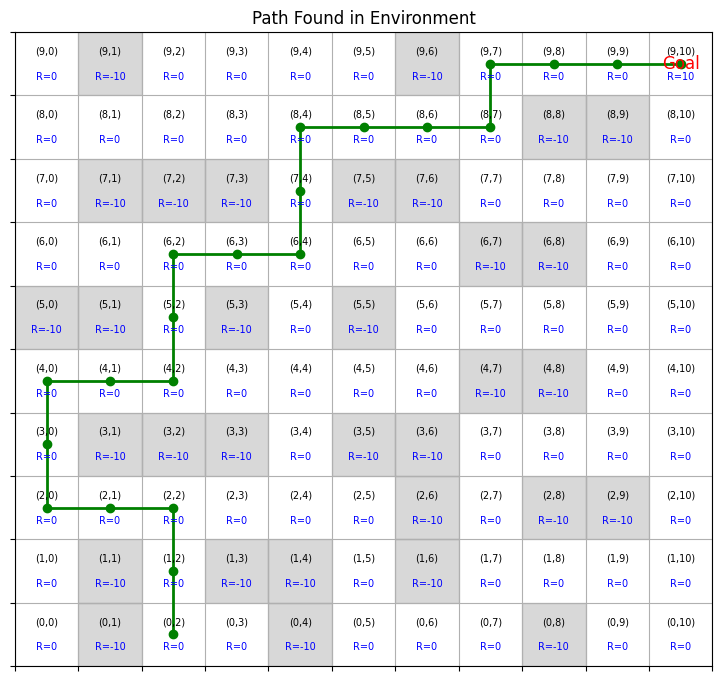

In [70]:
fig, ax = plt.subplots(figsize=(9, 9))

for i in range(grid_line):
    for j in range(grid_col):
        # Display of contact details and rewards
        ax.text(j, i + 0.2, f"({i},{j})", ha='center', va='center', fontsize=7)
        ax.text(j, i - 0.2, f"R={rewards[i, j]}", ha='center', va='center', color='blue', fontsize=7)
        
        # Walls in gray
        if rewards[i, j] < 0 and (i, j) != goal_state:
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color='gray', alpha=0.3))
        
        # Goal in red
        if (i, j) == goal_state:
            ax.text(j, i, "Goal", ha='center', va='center', color='red', fontsize=12)

# Tracer le chemin trouvé
if len(path) > 1:
    x_path = [p[1] for p in path]
    y_path = [p[0] for p in path]
    ax.plot(x_path, y_path, color='green', linewidth=2, marker='o')

ax.set_xticks(np.arange(- 0.5, grid_col, 1))
ax.set_yticks(np.arange(- 0.5, grid_line, 1))
ax.grid(True)
ax.set_aspect('equal')
ax.set_xlim(- 0.5, grid_col - 0.5)
ax.set_ylim(- 0.5, grid_line - 0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Path Found in Environment")

plt.show()
